# **Исследование продаж видеоигр и игровых платформ**

# **Содержание**

- Дано: исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. 
- Необходимо: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


**Описание данных:**
- Name — название игры
- Platform — платформа
- Year_of_Release — год релиза
- Genre — жанр игры
- NA_players — продажи игрокам в Северной Америке (в миллионах долларов)
- EU_players — продажи игрокам в Европе (в миллионах долларов)
- RU_players — продажи игрокам в России (в миллионах долларов)
- Other_players — продажи игрокам в других странах
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг ESRB

## Открытие файла и изучение полученных данных

Для начала, импортиурем все необходимые бибилиотеки, необходимые нам для дальнейшей работы

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as m

from scipy import stats as st
from matplotlib import pyplot as plt
from datetime import datetime as dt

#Перед началом работы импортируем все необходимые модули и инициализируем plotly с помощью команды init_notebook_mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.express as px
import plotly.graph_objs as go


init_notebook_mode(connected=True)

# отключим предупреждения
import warnings
warnings.simplefilter('ignore')

pd.options.display.float_format = '{:,.2f}'.format

Теперь, загрузим набор данных и исследуем его

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yandex.Prakticum/4. Исследование игр/games.csv')

Мы импортировали бибилиотеки и загрузили набор данных, приступим к анализу

## Предобработка данных

Необходимо:
- Заменить названия столбцов (по необходимости) и привести их к нижнему регистру;
- Преобразуйте данные в нужные типы;
- Обработать пропуски при необходимости;
- Опиcать причины, которые могли привести к пропускам;
- Отдельно обратить внимание на аббревиатуру 'tbd' в столбцах с рейтингом, разобрать это значение и описать, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец;
- Проверить дубликаты

Взглянем на таблицу

In [4]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
4677,World Soccer Jikkyou Winning Eleven 2000: U-23...,PS,"2,000.00",Sports,0.00,0.00,0.39,0.03,nan,NaN,NaN
15026,Juusanshi Engi Engetsu Sangokuden 2,PSP,"2,014.00",Action,0.00,0.00,0.02,0.00,nan,NaN,NaN
14155,PriPara Mezameyo! Megami no Dress Design,3DS,"2,016.00",Action,0.00,0.00,0.03,0.00,nan,NaN,NaN
30,Pokémon Yellow: Special Pikachu Edition,GB,"1,998.00",Role-Playing,5.89,5.04,3.12,0.59,nan,NaN,NaN
2217,Crash City Mayhem,GBA,"2,004.00",Racing,0.67,0.25,0.00,0.02,nan,NaN,NaN


Посмотрим общую информацию

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum().sort_values() #посмотрим, сколько всего пропущенных значений мы имеем

Platform              0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Name                  2
Genre                 2
Year_of_Release     269
User_Score         6701
Rating             6766
Critic_Score       8578
dtype: int64

**Промежуточный вывод о наблюдении по полученной информации**

- Довольно много пропусков в колонках Critic_Score, User_Score. Это могло возникнуть по технической ошибке, либо по причине того что на данной платформе игре не выставлялись оценки, либо они выставлялись на ресурсах, которые по каким-то причинам не попали в настоящий набор данных;
Помимо этого, User_Score имеет тип данных object, что не совсем корректно, учитывая что столбец отражает числовые данные пользовательских оценок.
- Также у колонки с датой релиза тип данных float64, что не совсем корректно для данных содержащих дату (год).
- Данные о продажах - млн. проданных копий - NA_sales, EU_sales, JP_sales содержат нули, что, возможно, говорит о том что в этой части света данная игра на конкретной платформе не выходила. 
Посмотрим, что со всем этим можно сделать.

**Но сначала, заменим названия столбцов, а точнее, приведем их к нижнему регистру**

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


Готово. 
Теперь перейдем к преобразованию типов данных.

Начнем с колонки с указанием даты релиза

Но для начала избавимся от строк с пропущенными значениями в столбце Year_of_Release, Genre и Name, т.к. их менее 2%.

In [ ]:
#удалим строки с пропущенными значениями
df.dropna(subset=['year_of_release', 'genre','name'], inplace=True)

In [ ]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'],format="%Y").dt.year #преобразуем в тип данных из текстового в "дата"

df['year_of_release'] = df['year_of_release'].apply(pd.to_numeric).astype('int32') #заменим тип данных на целочисленный

Теперь заменим тип данных в столбце user_score, т.к. в нем содержатся оценки пользователей. Заменим тип данных на числовой (float, т.к. оценки не целочисленные)

На данном этапе мы столкнулись с аббревиатурой 'tbd' в столбцах с рейтингом.
Разберем это значение и опишем, как его обработать.

Значение данной абревиатуры может быть следующим: 
- tbd (to be determined) -  «будет утверждено»; 
- to be discussed («выносится на обсуждение»)
- to be done («должно быть сделано»).
Так или иначе, в данной ситуации для дальнейшей работы с данными, нам необходимо заменить это значение на NaN (на ноль нельзя - т.к. есть пользовательская оценка равная нулю)

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [ ]:
#теперь tbd заменим на nan
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan

In [ ]:
# заменим тип данных на float
df['user_score'] = df['user_score'].apply(pd.to_numeric).astype('float')

Отдельно рассмотрим столбец critic_score

In [ ]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Мы видим, что он не содержит в себе числа после запятой, а соответственно можно было бы преобразовать его тип данных в целочисленный int. Однако данные содержат в себе NaN, и пока решено не заменять их на 0. Оставим как есть.

Пропущенные данные по рейтингу заменим на фразу without rating.

In [ ]:
df['rating'] = df['rating'].fillna('without rating',)

Добавим столбец с общим количеством проданных копий (млн. копий)

In [ ]:
#Создадим новый столбец total_sales и прибавим продажи всех столбцов
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Взглянем еще раз на получившиеся данные

In [ ]:
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,without rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,without rating,31.38


Проверим данные на дубликаты

In [ ]:
df.duplicated().sum()

0

Дубликатов не обнаружено, можно двигаться дальше.

**Вывод**
- Привели к правильному типу столбцы
- Привели к нижнему регистру названия колонок
- Дубликатов не имеется

## Исследовательский анализ данных

На данном этапе необходимо сделать следующее:
- 3.1. Посмотреть, сколько игр выпускалось в разные годы;
- 3.2. Проанализировать, как менялись продажи по платформам;
- 3.3. Выяснить, какие платформы лидируют по продажам, растут или падают?;
- 3.4. Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам и описать результат; Посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков; Соотнести выводы с продажами игр на других платформах;
- 3.5. Посмотреть на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### **Построим график продаж видео игр в различных странах в зависимости от года**

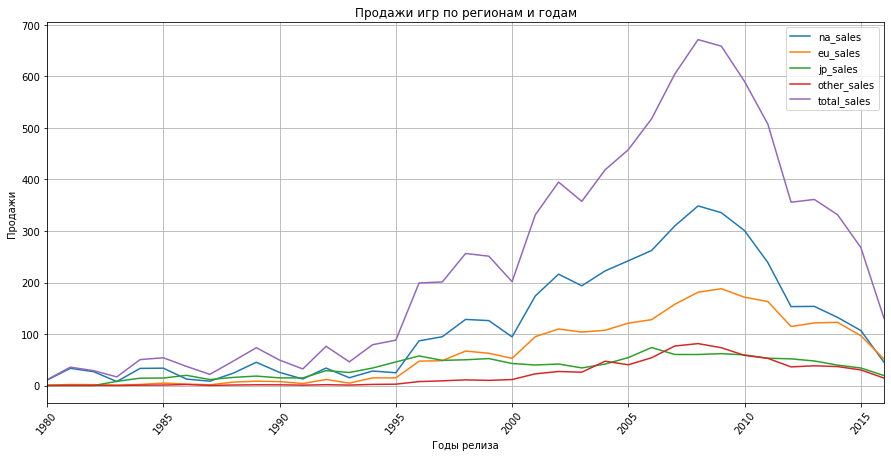

In [ ]:
sales_df = df[[x for x in df.columns if 'sales' in x] + ['year_of_release']]
sales_df.groupby('year_of_release').sum().plot(figsize=(15,7)) #зададим размеры графика

plt.xlabel(u'Годы релиза') #название Оси Х
plt.ylabel(u'Продажи')     #название Оси Y
plt.xticks(rotation=50)
plt.title(u'Продажи игр по регионам и годам') #название Графика
plt.grid(True)
plt.legend() 
plt.show()

Исходя из графика, мы видим, что данные располагаются между 1980 и 2016 годом.
До 1995 года рынок игр только формировался, поэтому данные до этого года не являются подходящими для дальнейшего анализа.

Пик продаж игр приходится на период с 2005 до 2010 года, что актуально для всех регионов продаж, после 2008 года начинается резкое падение. Возможно это произошло из-за того, что массово начали создавать мобильные приложения и мобильные игры.

### **Посмотрим как менялись продажи по платформам** 

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

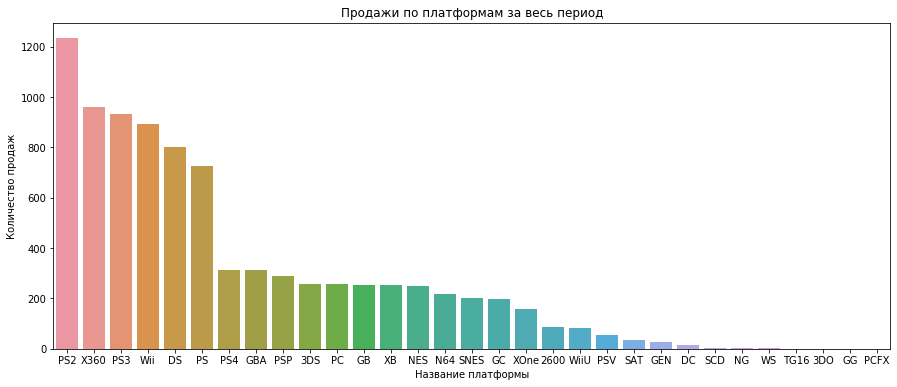

In [ ]:
#создадим pivot_table в разрезе платформ и продаж, отсортируем по продажам от большего к меньшему
platform_on_sales = df.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(15,6)) #зададим размер графику
sns.barplot(x=platform_on_sales.index,y=platform_on_sales['total_sales'])

plt.title("Продажи по платформам за весь период") #название графика
plt.xlabel("Название платформы") #название оси X
plt.ylabel("Количество продаж") #название оси Y

plt.show() #выведем график на экран

Исходя из графика, мы видим, что наибольшей популярностью пользуются платформы PS2, X360, PS3, Wii, DS, PS. У других платформ продажи существенно ниже.

In [ ]:
#сделаем срез наших данных, но только по годам начиная от 2000 года
df_actual_year = df.query('year_of_release > 1999')

In [ ]:
pivot_sales_platform = pd.pivot_table(df_actual_year,
                                      values = ['total_sales'],
                                      index = ['platform'], aggfunc='sum')
pivot_sales_platform.sort_values('total_sales', ascending = False).head(10)                            

,total_sales
platform,
PS2,"1,233.56"
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS4,314.14
GBA,312.88
PSP,289.53
3DS,257.81


Таким образом, мы выявили наиболее популярные Топ-5 платформ начиная с 2000 года - PS2, X360, PS3, Wii и DS

In [ ]:
# Напишем функцию, которая будет возвращать нужную сводную таблицу и выводить данные с 2000 года до 2017 года
def year_total_sale_for_platform(name, data):
    slicee = data[(data['platform'] == name) & (data['year_of_release'] > 2000)  & (data['year_of_release']< 2017)]
    total = slicee.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').sort_values('year_of_release', ascending=False)
    return total

In [ ]:
# Создадим свою таблицу по платформам и их общими продажам. отсортируем их по убыванию.
top_platforms = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
top_platforms = top_platforms.reset_index().rename_axis(None, axis=1)

In [ ]:
list_platforms = top_platforms.platform.tolist()

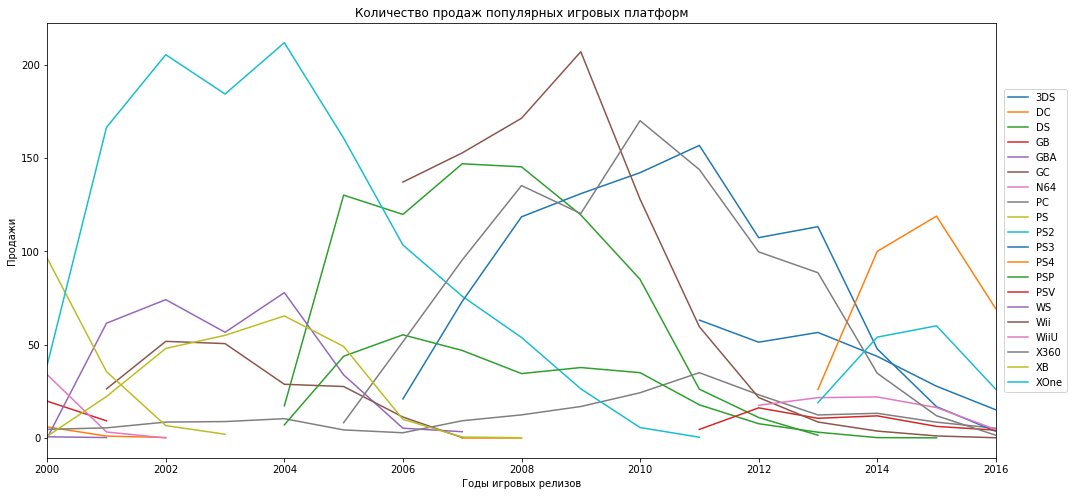

In [ ]:
#Отрисуем все игровые платформы и их поведение за последние 15 лет

df_platform = (df_actual_year
       .query('platform in @list_platforms')
       .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
       .plot(figsize=(17,8))
)
plt.legend(loc='center right',bbox_to_anchor = (1.08,0.5))

plt.title('Количество продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')

plt.grid(False)
plt.show()

Мы наблюдаем сильное падение в продажах по некоторым платформам к 2010 году, и в этот же год пик продаж у ряда других платформ.
После пика 2010 года заметно сокращение продаж у одних платформ и замещение новыми платформами.
Мы видим, что PS2 появляется примерно в 2001 и практически исчезает в 2011. DS появляется в 2004 и уходит с рынка в 2013. 
Годы жизни PS3 - 2006 - 2016. Аналогичная ситуация с Wii.

Наиболее полезным для нас будет период 2013 по 2016 год (с выпуска последних моделей, таких как PS4 и Xbox One).

Можно сделать вывод о том, что новая платформа выходит раз в год или два, а вот срок их жизни около 10 лет.
Самый пик наступает примерно через 5 лет после выхода приставки.

### Какие платформы лидируют по продажам, растут или падают?

Выясним, какие платформы лидируют по продажам, растут или падают. Выберите несколько потенциально прибыльных платформ.

Потенциально прибыльные платформы это те, продажи игр на которых в 2016-2017 достигли или достигнут своего пика, либо будут стремиться к нему.
Исходя из предыдущих наблюдений, нас мало интересуют платформы, на которых даты релиза игр начинаются до 2013 года, скорее всего наиболее прибыльными будут те, что появились после 2010 - 2011 года.

Создадим набор данных, в которых будут платформы с датами игровых релизов от 2013 года и более поздние, а также уберём те платформы, что уже не актуальны и их жизненный цикл подошел к концу

Выберем актуальный период

In [ ]:
df_actual_period = df.query('year_of_release >= 2013')

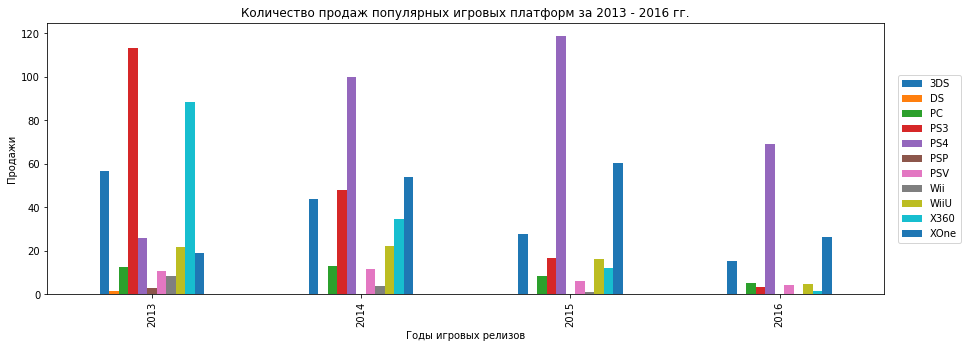

In [ ]:
(df_actual_period
       .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
       .plot(figsize=(15,5), kind='bar')
)


ax = plt.subplot()

ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.title('Количество продаж популярных игровых платформ за 2013 - 2016 гг.')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')

plt.grid(False)
plt.show()

На графике мы видим, что общая тенденция идет к снижению количества продаж по всем платформам к 2016 году (вероятно на это влияет неполноценнность данных за 2016 год.
Такие платформы как: PS3, X360, PSP, DS и Wii постепенно отмирают и в 2016 уже не актуальны.

Вероятно в 2017 году будут еще востребованы такие платформы как: PS4 (2013), 3DS (2011) и XONE (2013) в связи с из "свежестью", остальные же платформы уже подходят к завершению своего жизненного цикла. Платформа PSV вышла в одном году с 3DS (в 2011 году), однако у нее существенно ниже уровень продаж и популярности. 
Вероятно в последующих 2-3 годах будут лидировать платформы PS4 и XONE, и новые платформы, которые могли бы выйти в этот период.

In [ ]:
df_relevant_platform = df.query('year_of_release >= 2013 and platform in ("PS4","XOne","3DS")')

In [ ]:
df_relevant_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,nan,nan,without rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,nan,nan,without rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,nan,nan,without rating,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.00,4.30,E,8.58


Теперь построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам 

In [ ]:
# создаем Box trace для каждой платформы из наших данных
data = []
for platform in df_actual_period.platform.unique():
    data.append(
        go.Box(y=df_actual_period[df_actual_period.platform==platform].total_sales, name=platform)
    )

layout = {'title': 'Продажи по платформам','xaxis': {'title': 'Платформы'},'yaxis': {'title': 'Продажи'}}
# cоздаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
# визуализируем данные
iplot(fig, show_link = False)

In [ ]:
general_top_sales_platform = pd.pivot_table(df_actual_period,
                                      values = 'total_sales',
                                      index = 'platform', aggfunc='sum')
general_top_sales_platform.sort_values('total_sales', ascending = False).head(10)

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


У PS3 и X360 высокие продажи и есть успешные игры, но эти высокие показатели получены в 2013 году, и после 2013 данное поколение консолей уходит с рынка, уступая место PS4 и XOne. Поэтому, в дальнейшем анализе они нам не релевантны.

In [ ]:
data = []
for platform in df_relevant_platform.platform.unique():
    data.append(
        go.Box(y=df_relevant_platform[df_relevant_platform.platform==platform].total_sales, name=platform)
    )

layout = {'title': 'Продажи по платформам','xaxis': {'title': 'Платформы Топ-3'},'yaxis': {'title': 'Продажи'}}
# cоздаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
# визуализируем данные
iplot(fig, show_link = False)

Как видно из построенного графика, самые высокие продажи по медиане за период 2013 - 2016 гг. у XOne - 0.22, почти столько же у PS4 - 0.2, и 0.09 у 3DS. Однако, если смотреть на выбивающиеся значения, то супер-успешными оказались игры на PS4 и 3DS - у обеих платформ масимальные продажи составили 14 млн. копий.

In [ ]:
top_3_sales_platform = pd.pivot_table(df_relevant_platform,
                                      values = 'total_sales',
                                      index = 'platform', aggfunc='sum')
top_3_sales_platform.sort_values('total_sales', ascending = False).head() 

,total_sales
platform,
PS4,314.14
XOne,159.32
3DS,143.25


Можно сказать, что акутальные платформы, которые можно считать потенциально прибыльными, это следующие 3 платформы: PS4, Xbox-One, 3DS.

### Посмотрим, как влияют на продажи отзывы пользователей и критиков

На данном этапе нам необходимо проанализировать, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Необходимо построить диаграмму рассеяния и посчитать корреляцию между отзывами и продажами.

In [ ]:
#Корреляция между оценками пользователей и продажами PS4
sony_play_station4 = df[df['platform']=='PS4']
sony_play_station4['user_score'].corr(sony_play_station4['total_sales'])

-0.031957110204556424

In [ ]:
#Корреляция между оценкой критиков и продажами
sony_play_station4['critic_score'].corr(sony_play_station4['total_sales'])

0.40656790206178095

In [ ]:
fig = px.scatter(sony_play_station4, x='user_score', y='total_sales', title="Зависимость продаж от оценок пользователей")
fig.show()

При детальном рассмотрении графика рассеяния мы видим, что нет закономерности в продажи игр на платформе PS4 и пользовательской оценкой, что также подтверждается крайне низкой корреляцией. Конечно, есть игры с оценкой выше 9 и хорошими продажами (почти 4 млн. копий), но также есть высокие оценки от 8 баллов, но с низкими продажами (около 20 тысяч копий).

Взглянем на диаграмму рассеяния по оценкам критиков

In [ ]:
fig = px.scatter(sony_play_station4, x='critic_score', y='total_sales', title="Зависимость продаж от оценок критиков")
fig.show()

Исходя из показателя корреляции между оценкой критиков и продажами равной 40%, можно сказать что есть некоторая слабая зависимость. Также об этом говорит нам график рассеяния - чем ниже оценка критиков, тем ниже продажи. С другой стороны, это не является причиной: возможно игра действительно хорошая и критики ее хвалят, либо критикам нравится игра, а покупатели доверяют им, тем самым увеличивая продажи. Сказать однозначно что из этого является первопричиной довольно затруднительно, но можно исходить из того что действительно хорошая игра заслуживает и высоких оценок и высоких продаж. 
Однозначно можно сказать лишь то, что корреляция между продажами и оценками критиков намного выше, чем от оценок пользователей.

Можно сказать, что пользовательские оценки не влияют на продажи игр на PS4. 

**Соотнесем выводы с продажами игр на других платформах**

Автоматизируем получение графиков и выводов

In [ ]:
#Напишем функцию, которая будет отрисовывать графики рассеивания и считать корреляции
def other_platform_matrix(name_of_platform):                    #определим функцию
    platform = df[df['platform']==name_of_platform]             #определим переменную, 
                                                                #которую в дальнейшем будем использовать в цикле при построении графика 
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))               #определим размер обоих графиков
    
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])   #построим график №1
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1]) #построим график №2
    
    fig.suptitle(name_of_platform, fontsize=15)  #наименование графика = название платформы
    
    ax[0].set(xlabel='Оценка пользователей') #определим ось X первого графика   
    ax[1].set(xlabel='Оценка критиков')      #определим ось X второго графика  
    ax[0].set(ylabel='Количество продаж')    #определим ось Y первого графика  
    ax[1].set(ylabel='Количество продаж')    #определим ось Y второго графика  
    plt.show()                               #выведем графики на экран
    
    correl = platform['user_score'].corr(platform['total_sales'])
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    
    
    if 0.3 >= critic_correl >= 0.1:
        print('Корреляция между отзывами критиков и игровой платформой ', name_of_platform.upper(), ': Слабая', critic_correl)
    if 0.5 >= critic_correl >= 0.3:
        print('Корреляция между отзывами критиков и игровой платформой ', name_of_platform.upper(), ': Умеренная', critic_correl)
    if 0.7 >= critic_correl >= 0.5:
        print('Корреляция между отзывами критиков и игровой платформой ', name_of_platform.upper(), ': Высокая', critic_correl)
    if 1 >= critic_correl >= 0.7:
        print('Корреляция между отзывами критиков и игровой платформой ', name_of_platform.upper(), ': Сильная', critic_correl)
    
    if 0.3 >= correl >= 0.1:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform.upper(), ': Слабая', correl)
    if 0.5 >= correl >= 0.3:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform.upper(), ': Умеренная', correl)
    if 0.7 >= correl >= 0.5:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform.upper(), ': Высокая', correl)
    if 1 >= correl >= 0.7:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform.upper(), ': Сильная', correl)
    print('\n')

In [ ]:
#сделаем список из перспективных платформ, которые мы определили ранее
top_platform = ['XOne', 'PS4', '3DS']

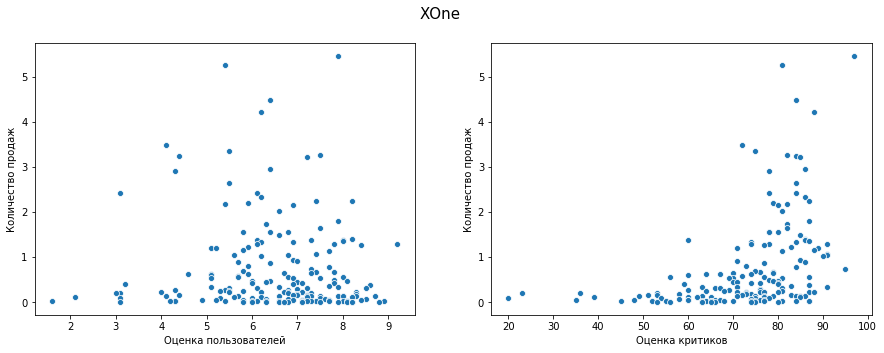

Корреляция между отзывами критиков и игровой платформой  XONE : Умеренная 0.4169983280084017




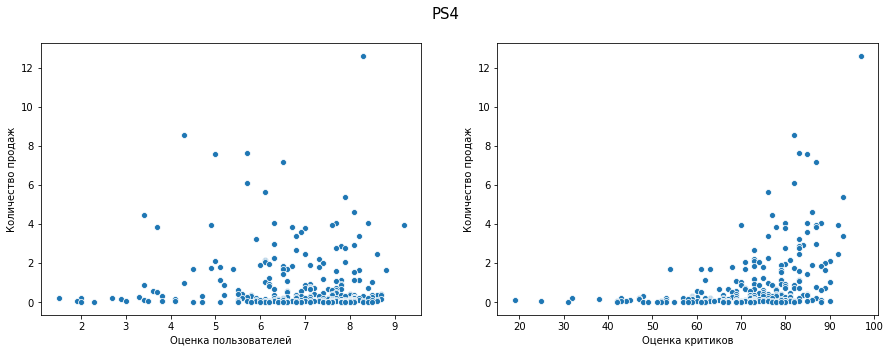

Корреляция между отзывами критиков и игровой платформой  PS4 : Умеренная 0.40656790206178095




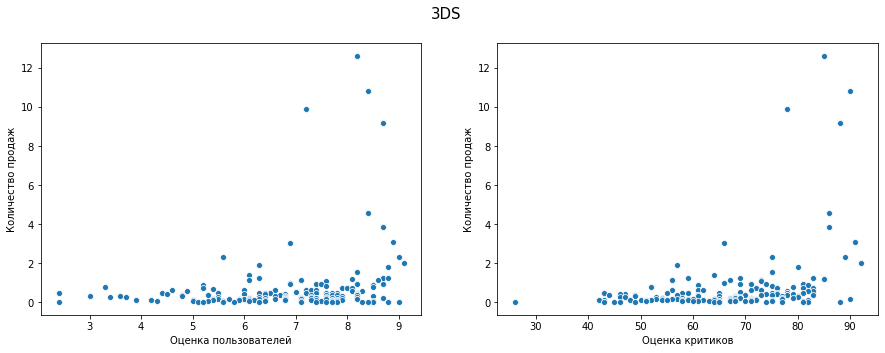

Корреляция между отзывами критиков и игровой платформой  3DS : Умеренная 0.3487397305984834
Корреляция между отзывами пользователей и продажами  3DS : Слабая 0.22207843643390882




In [ ]:
#С помощью цикла выведем все графики по нашему топу платформ
for platform in top_platform:
    other_platform_matrix(platform)

Можно сказать, что у всех платформ присутствуем корреляция между оценками критиков к продажам, чего нельзя сказать про оценки пользователей. Судя по всему, сами покупатели прислушиваются больше к критикам чем к оценкам других пользователей. 
Оценка пользователей слабо влияет на продажи.
Корреляция оценки критиков у двух платформ  - XOne и PS4 - примерно одинакова: порядка 40%. У портативной игровой приставки 3DS самая низкая корреляция, и соответственно, наиболее слабое влияние оценок критиков на продажи игр - порядка 35%. Видимо, пользователи портативных приставок больше полагаются на собственные личные предпочтения.

### Посмотрим на общее распределение игр по жанрам

Построим график распредления игр по жанрам за выбранный нами ранее период с 2013 по 2016 гг.

In [ ]:
fig_2 = px.bar(df_actual_period, x='genre', y='total_sales',
             labels={'total_sales':'Общие продажи','genre':'Жанр'}, title="Распределение игр по жанрам за 2013 - 2016 г.", height=400)

fig_2.show()

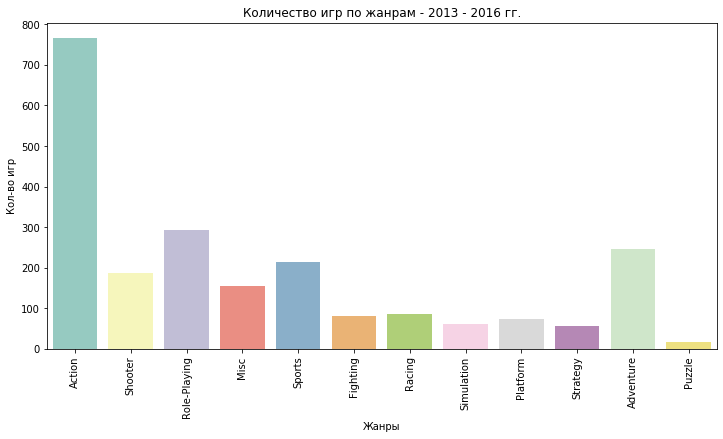

In [ ]:
#построим график для понимания кол-ва игровых наименований в зависимости от жанра
plt.subplots(figsize=(12,6))
sns.countplot(df_actual_period['genre'],palette='Set3')
plt.xticks(rotation=90)
plt.title('Количество игр по жанрам - 2013 - 2016 гг.')
plt.xlabel('Жанры')
plt.ylabel('Кол-во игр')
plt.show()

In [ ]:
#построим пивот с суммами продаж

pivot_genre = pd.pivot_table(df_actual_period,
                            values = 'total_sales',
                            index = 'genre',
                            aggfunc={'total_sales': ['median','sum']})

In [ ]:
pivot_genre.reset_index(inplace=True)
pivot_genre

,genre,median,sum
0,Action,0.11,321.87
1,Adventure,0.03,23.64
2,Fighting,0.12,35.31
3,Misc,0.10,62.82
4,Platform,0.22,42.63
5,Puzzle,0.06,3.17
6,Racing,0.12,39.89
7,Role-Playing,0.12,145.89
8,Shooter,0.45,232.98
9,Simulation,0.10,21.76


In [ ]:
data = []
for genre in df_actual_period.genre.unique():
    data.append(
        go.Box(y=df_actual_period[df_actual_period.genre==genre].total_sales, name=genre)
    )

layout = {'title': 'Продажи по жанрам за 2013-2016','xaxis': {'title': 'Жанры'},'yaxis': {'title': 'Продажи'}}
# cоздаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
# визуализируем данные
iplot(fig, show_link = False)

Наиболее прибыльными жанрами являются Action, Shooter, RPG, Sports и Adventure. Данные жанры выделяются довольно высокими продажами, по сравнению с другими. Жанр "Экшен" выделяется на фоне остальных: порядка 700 млн.копий и более 1,5 тысяч наименований игр. 
Самые низкие продажи у жанра Puzzle - всего лишь порядка 23 млн. копий и около 100 игровых наименований. На данный жанр не стоит делать ставку, планируя продажи.
Вместе с тем, у жанра Экшен довольно не высокий медианный показатель продаж (в целом 110 тыс. копий игр продано за 2013 -2016 годы). Самый высокий показатель продаж по медиане -  у жанра Shooter - 450 тысяч. копий, хотя и кол-во игр уступает жанру Экшен. 

**Вывод по исследовательскому блоку**

- Количество игр на игровые платформы начало расти с большой скоростью с 90х годов до 2008 года. С 2008 года, после того как массово начали создавать мобильные приложения и мобильные игры, произошел резкий спад разработок игр на игровые платформы.
- Самые популярные игровые платформы за весь период : Sony PlayStation 2, Xbox 360, Sony Playstation 3, Nintendo WII, Nintendo DS, Sony Playstation.
- Средняя жизнь игровой платформы составляет 10 лет. Пик продаж наступает примерно через 5 лет после выхода приставки.
- На текущий момент наиболее популярными платформами с потенциалом прибыли являются: PS4, Xbox-One, 3DS.
- У платформ наблюдается взаимосвязь между продажами и оценками критиков, а вот связи между продажами и оценками пользователей не наблюдается. Заметнее всего корреляция между оценками критиков и продажами. Можно предположить, что для людей мнение критиков важнее мнения других пользователей. Поэтому при планировании продаж игр не стоит ориентироваться на мнение пользователей.

## Составить портрет пользователя каждого региона

**Определите для пользователя каждого региона (NA, EU, JP):**
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Портрет пользователя для NA (North America)**

Построим пивот по платформам, жанрам и рейтингу для региона North America по наиболее актуальным данным за последние 3 года

In [ ]:
#Функция для создания сводных таблиц за последние 3 года
def for_pivot_2013(row, title):                 #определим функцию
    temp = df[df['year_of_release']>=2013]       #переменная temp будет содержать dataframe от 2013 года
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    for pivot, ax in zip(list(['platform','genre','rating']), axes.flatten()[:3]):
        #строим пивот таблицу в цикле
        ppivot = temp.pivot_table(index=pivot, values=row, aggfunc='sum').sort_values(by=row, ascending=False).reset_index().rename_axis(None, axis=1).head(5)
        print(ppivot)                           #выводим пивот на экран
        print('\n\n')                           #делаем отступы
        sns.barplot(data=ppivot, x=pivot, y=row, ax=ax)

        fig.suptitle(title, fontsize=15)

  platform  na_sales
0      PS4    108.74
1     XOne     93.12
2     X360     81.66
3      PS3     63.50
4      3DS     38.20



          genre  na_sales
0        Action    126.05
1       Shooter    109.74
2        Sports     65.27
3  Role-Playing     46.40
4          Misc     27.49



           rating  na_sales
0               M    165.21
1  without rating     89.42
2               E     79.05
3            E10+     54.24
4               T     49.79





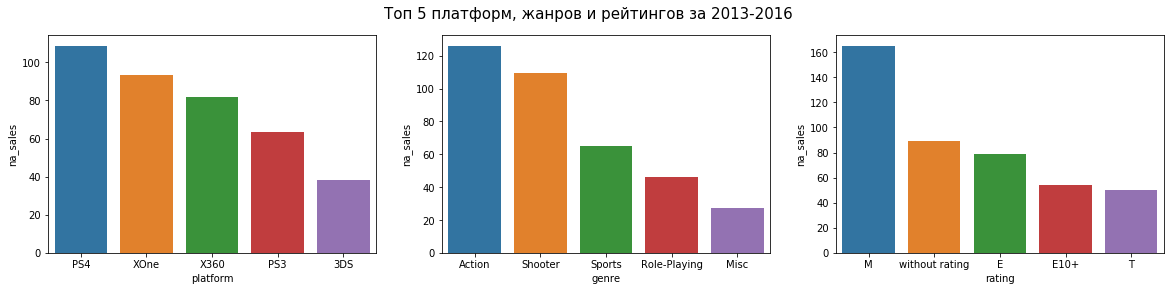

In [ ]:
#Выведем топ 5 платформ, жанров и рейтингов за последний год
for_pivot_2013('na_sales','Топ 5 платформ, жанров и рейтингов за 2013-2016')

In [ ]:
#построим круговые диаграммы за период 2013-2016 гг. по платформам, жанрам и рейтингу по Северной Америке

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['Платформы', 'Жанры','Рейтинг'])


labels_platform = df_actual_period['platform']
labels_genre = df_actual_period['genre']
labels_rating = df_actual_period['rating']


values = df_actual_period['na_sales']

fig.add_trace(go.Pie(labels=labels_platform, values=values,scalegroup='one',
                     name="platform"), 1, 1)
fig.add_trace(go.Pie(labels=labels_genre, values=values,scalegroup='one',
                     name="genre"), 1, 2)
fig.add_trace(go.Pie(labels=labels_rating, values=values,scalegroup='one',
                     name="rating"), 1, 3)

fig.update_layout(title_text='Распредление по платформам, жанрам и рейтингу в Северной Америке')
fig.show()


**Вывод:**

- Самые популярные игровые платформы в Северной Америке за последние три года: XBOX One и 360, PS4 и PS3, WII, 3DS
- Топ 5 жанров в северной америке за период с 2013 года: action, sports, shooter, RPG, misc
- По рейтингам видно, что больше всего продаж за последние три года у игр с рейтингом "М (старше 17 лет)", на втором месте игры без рейтинга,  и на третьем месте игры с рейтингом "E (для всех)"
- Возрастной рейтинг игры в Северной Америке прямым образом влияет на продажи: Игры с рейтингом М продаются явно лучше, чем игры расчитанные на более молодую аудиторию. Видимо на это влияет платежеспособный спрос со стороны более взрослой части населения, т.к. многие после 17-18 лет начинают зарабатывать самостоятельно.

**Портрет пользователя для EU (European Union)**

Построим пивот платформам, жанрам и рейтингу для региона European Union

  platform  eu_sales
0      PS4    141.09
1      PS3     67.81
2     XOne     51.59
3     X360     42.52
4      3DS     30.96



          genre  eu_sales
0        Action    118.13
1       Shooter     87.86
2        Sports     60.52
3  Role-Playing     36.97
4        Racing     20.19



           rating  eu_sales
0               M    145.32
1               E     83.36
2  without rating     78.91
3            E10+     42.69
4               T     41.95





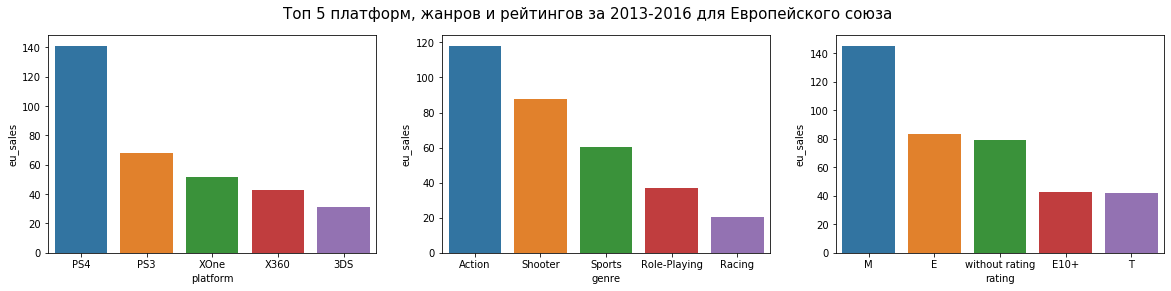

In [ ]:
#Выведем топ 5 платформ, жанров и рейтингов за последние 3 года для Европейского союза
for_pivot_2013('eu_sales','Топ 5 платформ, жанров и рейтингов за 2013-2016 для Европейского союза')

In [ ]:
#построим круговые диаграммы за период 2013-2016 гг. по платформам, жанрам и рейтингу по Европе

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['Платформы', 'Жанры','Рейтинг'])


labels_platform = df_actual_period['platform']
labels_genre = df_actual_period['genre']
labels_rating = df_actual_period['rating']


values = df_actual_period['eu_sales']

fig.add_trace(go.Pie(labels=labels_platform, values=values,scalegroup='one',
                     name="platform"), 1, 1)
fig.add_trace(go.Pie(labels=labels_genre, values=values,scalegroup='one',
                     name="genre"), 1, 2)
fig.add_trace(go.Pie(labels=labels_rating, values=values,scalegroup='one',
                     name="rating"), 1, 3)

fig.update_layout(title_text='Распредление по платформам, жанрам и рейтингу в Европе')
fig.show()

- Самые популярные игровые платформы в Европе это: PS4, PS3, XOne, X360, 3DS
- Топ 5 жанров в Европе : action, sports, shooter, racing, role-playing (RPG)
- По рейтингам видно, что больше всего продаж у игр с рейтингом "M (старше 17)", на втором месте игры с рейтингом "для всех" и на третьем месте игры без указания рейтинга

**Портрет пользователя для JP (Japanese)**

Построим пивот платформам, жанрам и рейтингу для региона Japanese

  platform  jp_sales
0      3DS     67.81
1      PS3     23.35
2      PSV     18.59
3      PS4     15.96
4     WiiU     10.88



          genre  jp_sales
0  Role-Playing     51.04
1        Action     40.49
2          Misc      9.20
3      Fighting      7.65
4       Shooter      6.61



           rating  jp_sales
0  without rating     85.05
1               T     20.59
2               E     15.14
3               M     14.11
4            E10+      5.89





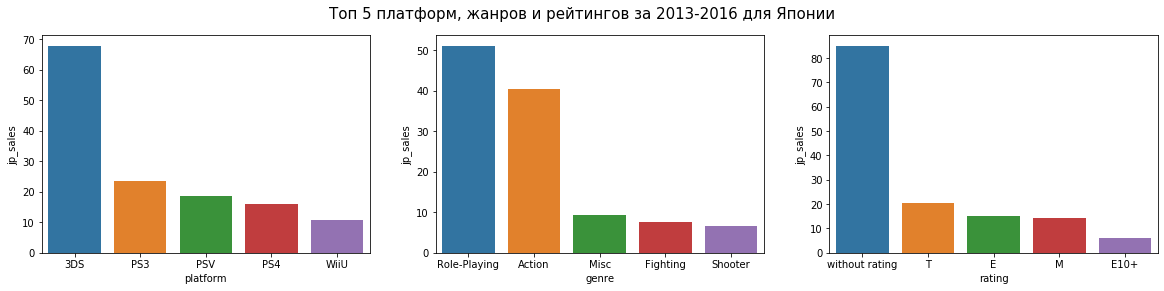

In [ ]:
#Выведем топ 5 платформ, жанров и рейтингов за последние 3 года для Японии
for_pivot_2013('jp_sales','Топ 5 платформ, жанров и рейтингов за 2013-2016 для Японии')

In [ ]:
#построим круговые диаграммы за период 2013-2016 гг. по платформам, жанрам и рейтингу по Европе

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['Платформы', 'Жанры','Рейтинг'])


labels_platform = df_actual_period['platform']
labels_genre = df_actual_period['genre']
labels_rating = df_actual_period['rating']


values = df_actual_period['jp_sales']

fig.add_trace(go.Pie(labels=labels_platform, values=values,scalegroup='one',
                     name="platform"), 1, 1)
fig.add_trace(go.Pie(labels=labels_genre, values=values,scalegroup='one',
                     name="genre"), 1, 2)
fig.add_trace(go.Pie(labels=labels_rating, values=values,scalegroup='one',
                     name="rating"), 1, 3)

fig.update_layout(title_text='Распредление по платформам, жанрам и рейтингу в Японии')
fig.show()

- Самые популярные игровые платформы в Японии это: WiiU, PSV, PS3, PS4, 3DS
- Топ 5 жанров в Японии : Role-Playing, action, misc, fighting, shooter
- По рейтингам видно, что больше всего продаж у игр без рейтинга, на втором месте игры с рейтингом "от 13 и выше" и на третьем месте игры с рейтингом "для всех",  и чуть менее популярны игры с рейтингом от 17 лет и старше.

**Вывод по составлению портрета пользователя каждого региона**

Америка:
- Самые популярные игровые платформы в Северной Америке за последние три года: XBOX One и 360, PS4 и PS3, WII, 3DS
- Топ 5 жанров в северной америке за период с 2013 года: action, sports, shooter, RPG, misc
- По рейтингам видно, что больше всего продаж за последние три года у игр с рейтингом "М (старше 17 лет)", на втором месте игры без рейтинга,  и на третьем месте игры с рейтингом "E (для всех)"


Европа:
- Самые популярные игровые платформы в Европе это: PS4, PS3, XOne, X360, 3DS
- Топ 5 жанров в Европе : action, sports, shooter, racing, role-playing (RPG)
- По рейтингам видно, что больше всего продаж у игр с рейтингом "M (старше 17)", на втором месте игры с рейтингом "для всех" и на третьем месте игры без указания рейтинга

Япония:
- Самые популярные игровые платформы в Японии это: WiiU, PSV, PS3, PS4, 3DS
- Топ 5 жанров в Японии : Role-Playing, action, misc, fighting, shooter
- По рейтингам видно, что больше всего продаж у игр без рейтинга, на втором месте игры с рейтингом "от 13 и выше" и на третьем месте игры с рейтингом "для всех",  и чуть менее популярны игры с рейтингом от 17 лет и старше.

*Сравнение занимаемых долей рынка по регионам:*

Платформы: Наибольшую долю рынка в Европе и Америке занимает PS4 (36% и 25% соответственно), в то время как в Японии - портативная консоль 3DS (48% рынка). Видимо, это специфика игрового рынка Японии больше ориентированнного на внутренних пользователей.
Жанры: В Америке и Европе наибольшею долю занимают жанры Action и Shooter (почти по 30%), в Японии немного другая картина: Action также занимает существенную долю (28%), однако лидирует жанр RPG (36% от всего рынка). 
Рейтинги: По 37% занимают игры с рейтингом М в Америке и Европе, в то время как в Японии 60% игрового рынка не подпадает под систему оценок рейтингов ESRB.

В целом, можно сказать что игровой рынок Европы и Америки достаточно схожий, а в Японии довольно специфический, поэтому планируя покупать какие-либо игры онлайн магазину игр лучше ориентироваться на европейских и американских потребителей. 

Для прогноза будущих продаж лучше брать данные за последние годы, так как разивтие технологий происходит быстрыми темпами, и это касается как игр, так и платформ. Поэтому, для 2017 года большую часть прибыли будут приносить игры жанра Action или Shooter, для платформы PS4 и с рейтингом "от 17 лет и старше".

## Проверить гипотезы

В ходе последнего этапа исследования нам необходимо проверить следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

**Сформулируем нулевые гипотезы:**

- Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [ ]:
# Сохраним в переменных xbox_hyp и pc_hyp соответствующие данные (актуальные данные за период 2013-2016)
xone_hyp = df_actual_period[(df_actual_period['platform']=='XOne')]['user_score']
pc_hyp = df_actual_period[(df_actual_period['platform']=='PC')]['user_score']

In [ ]:
#Посчитаем средний рейтинг пользователя для xbox платформ
xone_hyp.mean()

6.521428571428572

In [ ]:
#Посчитаем средний рейтинг пользователя для PC платформ
pc_hyp.mean()

6.269677419354839

In [ ]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind
#уровень значимости alpha равный 1% кажется вполне достаточным и убедительным
alpha = 0.01

results = st.ttest_ind(xone_hyp.dropna(), pc_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Значение p-value равно около 14,8%. Таким образом, не получилось отвергнуть Нулевую гипотезу. То есть, с вероятностью почти 15% можно получить различность рейтингов двух платформ. В целом, это действительно так: многие игры выходят как на платформе Xbox-One, так и на PC, и закономерно что оценки пользователей не должны сильно различаться. 

**Средние пользовательские рейтинги жанров Action и Sports разные**

**Сформулируем нулевые гипотезы:**

- Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые
- Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются

In [ ]:
# Сохраним в переменных genre_action_hyp и genre_sports_hyp соответствующие данные с пользовательскими оценками
genre_action_hyp = df_actual_period[(df_actual_period['genre']=='Action')]['user_score']
genre_sports_hyp = df_actual_period[(df_actual_period['genre']=='Sports')]['user_score']

#выведем среднюю оценку по жанру экшн
genre_action_hyp.mean()

6.837532133676093

In [ ]:
#выведем среднюю оценку по жанру спорт
genre_sports_hyp.mean()

5.238124999999999

In [ ]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = 0.01

results = st.ttest_ind(genre_action_hyp.dropna(), genre_sports_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Вывод:** Получив p-value меньше уровня существенности, мы отвергли Нулевую гипотезу. Таким образом, вероятность получить одинаковые средние рейтинги по двум жанрам крайне мала.

## Общий вывод

- В процессе предобработки данных, мы привели столбцы к правильным типам, проверили наши данные на дубликаты, названия столбцов привели к нижнему регистру.
- Определили, что аббревиатура TBD значит to be determined, to be done. То есть данные были нарочно не заполнены. Поэтому заменили tbd на nan для проведения дальнейшего анализа
- Пик продаж игр приходится на период с 2005 до 2010 года, что актуально для всех регионов продаж, после 2008 года начинается резкое падение. Возможно это произошло из-за того, что массово начали создавать мобильные приложения и мобильные игры.

- Также мы выявили, что средняя продолжительность жизни игровой приставки составляет порядка 10 лет. Самый пик продаж наступает примерно через 5 лет после выпуска консоли

- Мы провели анализ оценок пользователей и критиков. Можно сказать, что у всех платформ присутствуем слабая корреляция между оценками критиков к продажам, а оценки пользователей на продажи не влияют совершенно. Судя по всему, сами покупатели прислушиваются больше к критикам чем к оценкам других пользователей. Корреляция оценки критиков у двух платформ  - XOne и PS4 - примерно одинакова: порядка 40%. У портативной игровой приставки 3DS самая низкая корреляция, и соответственно, наиболее слабое влияние оценок критиков на продажи игр - порядка 35%. Видимо, пользователи портативных приставок больше полагаются на собственные личные предпочтения.

- Так же определили, что самый популярный жанр за все время это Action.

После мы составили портреты пользователей каждого региона.
Для Северной Америки самые популярные игровые платформы: XBOX One и 360, PS4 и PS3, WII, 3DS. Наиболее популярные жанры: action, sports, shooter, RPG, misc. По рейтингам видно, что больше всего продаж у игр с рейтингом "М (старше 17 лет)", на втором месте игры без рейтинга,  и на третьем месте игры с рейтингом "E (для всех)".

Для Европы Самые популярные игровые платформы в Европе это: PS4, PS3, XOne, X360, 3DS. Наиболее популярные жанры: action, sports, shooter, racing, role-playing (RPG). По рейтингам видно, что больше всего продаж у игр с рейтингом "M (старше 17)", на втором месте игры с рейтингом "для всех" и на третьем месте игры без указания рейтинга

Для Японии самые популярные игровые платформы в Японии это: WiiU, PSV, PS3, PS4, 3DS. Наиболее популярные жанры: : Role-Playing, action, misc, fighting, shooter
- По рейтингам видно, что больше всего продаж у игр без рейтинга, т.к. игры в Японии больше ориентированы на внутреннего потребителя, на втором месте игры с рейтингом "от 13 и выше" и на третьем месте игры с рейтингом "для всех",  и чуть менее популярны игры с рейтингом от 17 лет и старше.

В целом о влиянии возрастного рейтинга можно сказать, что возрастной рейтинг игры прямым образом влияет на продажи: Игры с рейтингом М продаются явно лучше, чем игры расчитанные на более молодую аудиторию. Видимо на это влияет платежеспособный спрос со стороны более взрослой части населения, т.к. многие после 17-18 лет начинают зарабатывать самостоятельно.

Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как Sony Playstation 4
Жанр необходимо выбирать Shooter или Action и выбирать игры с рейтингом "от 17 и выше", при этом больше ориентироваться на рынки Европы и Америки, тогда продажи будут значительно больше, чем если продавать игры с другим жанром/рейтингом.